In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import statsmodels.api as sm

def print_custom_summary(model):
    """Print OLS summary with only p-values and significance stars, removing P>|t| and confidence intervals."""
    # Get the summary table
    summary = model.summary()
    
    # Extract the table as a DataFrame
    summary_tables = summary.tables
    params_table = summary_tables[1]
    
    # Convert to DataFrame for easier manipulation
    # The params_table is a SimpleTable, we need to extract data
    data = []
    headers = params_table.headers
    for row in params_table.data:
        data.append([cell.strip() for cell in row])
    
    df = pd.DataFrame(data[1:], columns=headers)
    
    # Find column indices
    coef_idx = headers.index('coef')
    std_err_idx = headers.index('std err')
    t_idx = headers.index('t')
    pval_idx = headers.index('P>|t|')
    
    # Create new DataFrame with only desired columns
    result_df = pd.DataFrame()
    result_df[''] = df.iloc[:, 0]  # Variable name
    result_df['coef'] = df.iloc[:, coef_idx]
    result_df['std err'] = df.iloc[:, std_err_idx]
    result_df['t'] = df.iloc[:, t_idx]
    
    # Get p-values and add stars
    pvals = pd.to_numeric(df.iloc[:, pval_idx], errors='coerce')
    
    # Add significance stars
    stars = pd.Series([''] * len(pvals))
    stars[pvals < 0.001] = '***'
    stars[(pvals >= 0.001) & (pvals < 0.01)] = '**'
    stars[(pvals >= 0.01) & (pvals < 0.05)] = '*'
    
    # Format p-values with stars
    pval_str = pvals.apply(lambda x: f'{x:.4f}' if pd.notna(x) else '')
    result_df['P>|t|'] = pval_str + stars
    
    # Print the model info (first table)
    print(summary_tables[0])
    print()
    
    # Print formatted table
    print(result_df.to_string(index=False))
    print()
    
    # Print notes if available
    if len(summary_tables) > 2:
        print(summary_tables[2])



In [55]:
merged_data_path = os.path.join(os.getcwd(), 'data', 'merged_data')
master_train_path = os.path.join(merged_data_path, 'master_train.csv')
master_forecast_path = os.path.join(merged_data_path, 'master_forecast.csv')
df_master_train = pd.read_csv(master_train_path, low_memory=False)
df_master_train['date'] = pd.to_datetime(df_master_train['date'])
df_master_train = df_master_train.convert_dtypes()
df_master_forecast = pd.read_csv(master_forecast_path, low_memory=False)
df_master_forecast['date'] = pd.to_datetime(df_master_forecast['date'])
df_master_forecast = df_master_forecast.convert_dtypes()

In [56]:
# Missing data check - now that we have filled the null discountPct
missing_data = df_master_train.isnull().sum()
missing_pct = (missing_data / len(df_master_train)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print(missing_df)

# Save the null-handled training data back to the same file
df_master_train.to_csv(master_train_path, index=False)


                  Missing Count  Missing Percentage
promo_id                 297837           86.618545
discountPct              297837           86.618545
holidayEventName         271609           78.990778
FSC_index                    18            0.005235


In [57]:
df = df_master_train.copy()

# promo_id is not used in the model, the rest are subsumed by other variables
df = df.drop(columns=["promo_id", "category", "holidayEventIndicator", "workingDayIndicator"], errors="ignore")
df = df.dropna(subset=["FSC_index"])                 # drop obs if FSC_index is null
df["discountPct"] = df["discountPct"].fillna(0)      # set discountPct null to 0
df["holidayEventName"] = df["holidayEventName"].fillna("__NO_EVENT__")

cat_cols = ["mainProductGroup", "holidayEventName", "doWName"]

for c in cat_cols:
    print(f"\n{c} value counts:")
    print(df[c].value_counts())



mainProductGroup value counts:
mainProductGroup
Rood stevig                   22793
Rood soepel                   21659
others - Zoetwaren            21643
Vis                           21565
Wasmiddelen                   21560
Afwas                         21450
others - Vlees, Kip en Vis    21447
Vleesconserven                21446
Lucht                         21444
chocolade                     21418
others - Wijn en PSV          21380
Wit vol                       21342
Wit fris&fruitig              21313
suikerwerk                    21294
Visconserven                  21128
Vlees                         20949
Name: count, dtype: Int64

holidayEventName value counts:
holidayEventName
__NO_EVENT__             271608
Sinterklaas_lag_5           973
Nieuwjaar_lead_1            963
Eerste Paasdag_lag_1        963
Goede Vrijdag               963
                          ...  
Bevrijdingsdag_lead_1       239
Moederdag_lag_5             239
Moederdag_lag_4             239
Hemelvaart_l

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343831 entries, 0 to 343848
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                343831 non-null  datetime64[ns]
 1   articleId           343831 non-null  string        
 2   storeCount          343831 non-null  Int64         
 3   FSC_index           343831 non-null  Float64       
 4   sales_volume_index  343831 non-null  Float64       
 5   discountPct         343831 non-null  Float64       
 6   mainProductGroup    343831 non-null  string        
 7   holidayEventName    343831 non-null  string        
 8   doWName             343831 non-null  string        
 9   max_temp            343831 non-null  Int64         
 10  min_temp            343831 non-null  Int64         
 11  sunshine_hours      343831 non-null  Int64         
 12  precip_duration     343831 non-null  Int64         
 13  mean_wind_speed     343831 non-nul

In [59]:
print(f"\n{"holidayEventName"} value counts:")
print(df["holidayEventName"].value_counts().to_string())



holidayEventName value counts:
holidayEventName
__NO_EVENT__                 271608
Sinterklaas_lag_5               973
Nieuwjaar_lead_1                963
Eerste Paasdag_lag_1            963
Goede Vrijdag                   963
Goede Vrijdag_lag_1             962
Tweede Paasdag                  962
Goede Vrijdag_lag_2             962
Goede Vrijdag_lag_3             962
Goede Vrijdag_lag_4             961
Goede Vrijdag_lag_5             961
Valentijn_lag_2                 959
Moederdag                       959
Moederdag_lag_1                 959
Valentijn_lag_1                 959
Moederdag_lag_2                 959
Valentijn                       959
Hemelvaart_lag_2                958
Vaderdag_lag_2                  958
Bevrijdingsdag                  958
Hemelvaart_lag_3                958
Vaderdag_lag_1                  957
Vaderdag                        957
Vaderdag_lead_1                 957
Koningsdag_lag_5                957
Koningsdag_lag_4                957
Koningsdag_lag_

In [60]:
# Define desired baselines
baseline_map = {
    "mainProductGroup": "Other",
    "holidayEventName": "__NO_EVENT__",
    "doWName": "Maandag"
}

for col, baseline in baseline_map.items():
    if col in df.columns:
        # Get all existing levels
        levels = df[col].astype("string").unique().tolist()
        # Put baseline first, keep others after
        ordered_levels = [baseline] + [x for x in levels if x != baseline]
        # Enforce category order
        df[col] = pd.Categorical(df[col], categories=ordered_levels, ordered=True)


In [61]:
df['sales_volume_index'] = np.log(df['sales_volume_index'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     94.46
Date:                Thu, 15 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:21:15   Log-Likelihood:                 198.49
No. Observations:                1429   AIC:                            -187.0
Df Residuals:                    1324   BIC:                             365.8
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

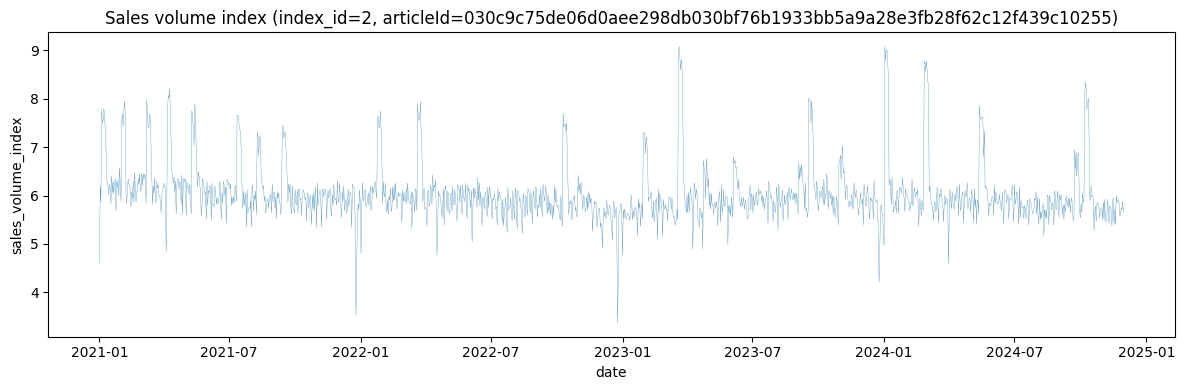

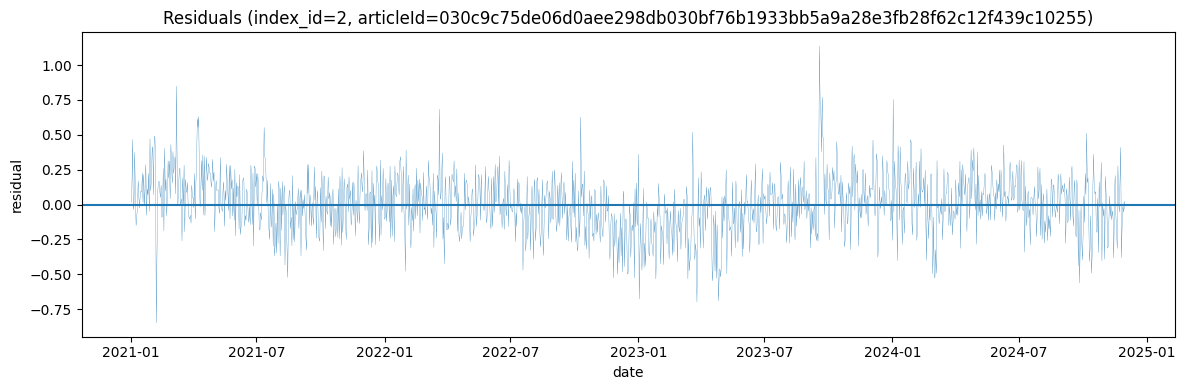

{'index_id': 2,
 'articleId': '030c9c75de06d0aee298db030bf76b1933bb5a9a28e3fb28f62c12f439c10255',
 'mainProductGroup': ['Vis'],
 'n_rows': 1430,
 'date_min': Timestamp('2021-01-01 00:00:00'),
 'date_max': Timestamp('2024-11-30 00:00:00')}

In [73]:

# --- sequential index (1..N) -> articleId mapping ---
article_list = (
    df["articleId"]
    .dropna()
    .astype("string")
    .drop_duplicates()
    .sort_values()
    .to_list()
)
n_articles = len(article_list)

index_map = pd.DataFrame({
    "index_id": np.arange(1, n_articles + 1),
    "articleId": article_list
})

# --- run per-article OLS + plots + attributes ---
def run_article_ols(index_id: int):
    if not (1 <= index_id <= n_articles):
        raise ValueError(f"index_id must be in [1, {n_articles}]")

    aid = article_list[index_id - 1]
    d = df.loc[df["articleId"] == aid].sort_values("date")

    # attributes (returned)
    attrs = {
        "index_id": index_id,
        "articleId": aid,
        "mainProductGroup": d["mainProductGroup"].dropna().unique().tolist(),
        "n_rows": int(len(d)),
        "date_min": d["date"].min(),
        "date_max": d["date"].max(),
    }

    y = d["sales_volume_index"].astype(float)

    base_cols = [
        "storeCount", "FSC_index", "discountPct",
        "max_temp", "min_temp", "sunshine_hours", "precip_duration",
        "mean_wind_speed", "max_gust"
    ]
    X = d[base_cols].astype(float)
    
    # Add lagged 1 day sales_volume_index
    X["sales_volume_index_lag1"] = d["sales_volume_index"].shift(1).astype(float)
    X["sales_volume_index_lag3"] = d["sales_volume_index"].shift(1).astype(float)

    # categorical controls
    cat = pd.get_dummies(d[["holidayEventName", "doWName"]], drop_first=True)
    X = pd.concat([X, cat], axis=1)
    X = sm.add_constant(X, has_constant="add")

    # align + drop missing
    dm = pd.concat([d[["date"]], y.rename("y"), X], axis=1).dropna()
    dates = dm["date"]
    y_m = dm["y"]
    X_m = dm.drop(columns=["date", "y"])
    
    # Convert all columns to numeric (float) to avoid object dtype issues
    # This converts boolean columns from get_dummies to 0.0/1.0
    X_m = X_m.astype(float)

    model = sm.OLS(y_m, X_m).fit()

    # --- outputs ---
    print(model.summary())

    # original time series
    plt.figure(figsize=(12, 4))
    plt.plot(d["date"], d["sales_volume_index"].astype(float),linewidth=0.2)
    plt.title(f"Sales volume index (index_id={index_id}, articleId={aid})")
    plt.xlabel("date"); plt.ylabel("sales_volume_index")
    plt.tight_layout()
    plt.show()

    # residuals
    plt.figure(figsize=(12, 4))
    plt.plot(dates, model.resid, linewidth=0.2)
    plt.axhline(0)
    plt.title(f"Residuals (index_id={index_id}, articleId={aid})")
    plt.xlabel("date"); plt.ylabel("residual")
    plt.tight_layout()
    plt.show()

    return attrs

# Example:
attrs = run_article_ols(2)
attrs
